# Clustering CNN Data #

In this notebook I try Kmeans clustering on CNN data to see if automatically assigned clusters can help determine which sentences are ads.

In [1]:
import re

import pandas as pd

import matplotlib.pyplot as plt

import pickle

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\linne\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
cnn_df = pd.read_csv('../data/interim/cnn-last-year-sent-comb.csv')
cnn_df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sentence,start_snip,end_snip,contributor,runtime,start_time,stop_time,identifier,subjects
0,0,0,0,to get challenge.,0,60,CNNW,01:00:58,2019-05-28 17:00:00,2019-05-28 18:00:59,CNNW_20190528_170000_CNN_Right_Now_With_Briann...,"['joe biden', 'oklahoma', 'john mccain', 'bide..."
1,1,1,1,hillary clinton did in 2016 and survived but i...,0,60,CNNW,01:00:58,2019-05-28 17:00:00,2019-05-28 18:00:59,CNNW_20190528_170000_CNN_Right_Now_With_Briann...,"['joe biden', 'oklahoma', 'john mccain', 'bide..."
2,2,2,2,a busy news day. stay right there.,0,60,CNNW,01:00:58,2019-05-28 17:00:00,2019-05-28 18:00:59,CNNW_20190528_170000_CNN_Right_Now_With_Briann...,"['joe biden', 'oklahoma', 'john mccain', 'bide..."
3,3,4,4,brianna keilar starts right now.,0,60,CNNW,01:00:58,2019-05-28 17:00:00,2019-05-28 18:00:59,CNNW_20190528_170000_CNN_Right_Now_With_Briann...,"['joe biden', 'oklahoma', 'john mccain', 'bide..."
4,4,5,5,i'm brianna keilar live from cnn's washington...,0,60,CNNW,01:00:58,2019-05-28 17:00:00,2019-05-28 18:00:59,CNNW_20190528_170000_CNN_Right_Now_With_Briann...,"['joe biden', 'oklahoma', 'john mccain', 'bide..."


In [4]:
len(cnn_df)

3460457

This is a massive dataset, 3.5 million sentences, so I'm going to get a random 10% of it to work with.

In [5]:
cnn_df, _ = train_test_split(cnn_df.drop(columns=['Unnamed: 0', 
                                                  'Unnamed: 0.1',
                                                 'Unnamed: 0.1.1']).dropna(), test_size=0.9, random_state=18)
len(cnn_df)

346045

In [6]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could',
                           '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many',
                           'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily',
                           'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right',
                           'line', 'even', 'also', 'may', 'take', 'come', 'hi', 'ha', 'le', 'u', 'wa', 'thi',
                           'to', 'one'])

In [7]:
def clean_sent(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = re.sub("([\d,\,\./!#$%&\'\":;>\?@\[\]`)(\+])+", "", sent) # remove digits and remove punctuation
        sent = re.sub("([-])+", " ", sent)
        yield(sent)  

In [8]:
corpus = list(clean_sent(cnn_df.sentence.values.tolist()))
corpus[:5]

['before taking ibrance tell your doctor if you have fever chills or other signs of infection liver or kidney problems are pregt breastfeeding or plan to become pregt',
 ' the army core ils ves very prepared to do as we say and we are looking at where we are going',
 'but thanks to congress permanently extending the victim compensation fund youre not taking mona way from anyone',
 'senator so glad you can be with me right now',
 ' reporter democratic leaders deliberately tailored to just about the tweets']

From some previous experimentation with Fox data, I found that TfidF vectorization with bigrams gave the easiest-to-interpret kmeans clusters and that 75 clusters separated out a lot of ad copy

In [9]:
#lemmatize before vectorizing

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

vect = TfidfVectorizer(tokenizer=LemmaTokenizer(), strip_accents='unicode', stop_words='english', 
                       min_df=2, max_df=0.3, ngram_range=(2,2))

In [10]:
pickle.dump(vect, open('../models/cnn_vect.p', 'wb'))

In [11]:
cnn_bow = vect.fit_transform(corpus)
vect.get_feature_names()

C:\Users\linne\Anaconda3\envs\ad-finder-cc\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


['aa aa',
 'aa aye',
 'aa battery',
 'aa group',
 'aag best',
 'aag introducing',
 'aag trust',
 'aag working',
 'aags free',
 'aags new',
 'aap rocky',
 'aaron david',
 'aaron dean',
 'aaron neville',
 'aaron rodgers',
 'aaron thank',
 'aarp advocate',
 'aarp auto',
 'aarp community',
 'aarp endorsement',
 'aarp force',
 'aarp ha',
 'aarp high',
 'aarp medicare',
 'aarp meet',
 'aarp member',
 'aarp thats',
 'ab ab',
 'ab tract',
 'abaco bahamas',
 'abaco grand',
 'abaco island',
 'abacos grand',
 'abandon ally',
 'abandon idea',
 'abandon kurd',
 'abandon kurdish',
 'abandoned house',
 'abandoning ally',
 'abbe confidentth',
 'abbott getting',
 'abbott make',
 'abbott rapid',
 'abbott technology',
 'abbott test',
 'abbvie able',
 'abby mentioned',
 'abby philip',
 'abby phillip',
 'abby phillips',
 'abby senator',
 'abby thank',
 'abby wa',
 'abby week',
 'abc came',
 'abc dancing',
 'abc news',
 'abc newswashington',
 'abc poll',
 'abdication loom',
 'abdication responsibility',
 'a

In [12]:
kmeans = KMeans(n_clusters=75, random_state=18)
results = kmeans.fit_predict(cnn_bow)
pickle.dump(kmeans, open('../models/cnn_kmeans.p', 'wb'))

In [13]:
#print out most indicative words
terms = vect.get_feature_names()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(75):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])
    print()

Cluster 0:
 russia want
 doing russia
 ukraine russia
 involved thats
 rest world
 state doing
 want involved
 theory bolster
 russia case
 case russia

Cluster 1:
 fact check
 trump fact
 daniel dale
 check ahead
 check daniel
 check president
 going fact
 check fly
 president say
 flunk fact

Cluster 2:
 hong kong
 street hong
 live hong
 ivan watson
 kong protester
 u hong
 pro democracy
 kong government
 cnn hong
 mainland china

Cluster 3:
 just beginning
 really just
 understand just
 say just
 bad ha
 know just
 think just
 presidency just
 japan just
 thats way

Cluster 4:
 president trump
 white house
 united state
 new york
 joe biden
 donald trump
 dont think
 im going
 dont want
 bernie sander

Cluster 5:
 doing best
 im doing
 showing doing
 wa showing
 know doing
 best help
 theyre doing
 guard doing
 today clean
 best contain

Cluster 6:
 cashback rakuten
 clothing earning
 earning cashback
 rakuten just
 constantly growing
 growing clothing
 theyre constantly
 child the

I did attempt other types of clustering algorithms, but they all killed my computer with even 10,000 sentences, so I've stuck with KMeans and LDA (to follow).

In [14]:
# add results to cnn data frame
cnn_df['cluster'] = results

In [15]:
# view sentences for each cluster
file_contents = ''
for i in range(75):
    file_contents += 'Cluster {}\n'.format(i)
    counter = 0
    for index, row in cnn_df[cnn_df.cluster == i].iterrows():
        file_contents += row['sentence'] + '\n'
        counter += 1
        if counter > 20:
            break
    file_contents += '\n'
with open('../data/interim/cnn-sentence-check.txt', 'w') as f:
    f.write(file_contents)

In [16]:
# count number of sentences in each cluster
cnn_df[['cluster', 'sentence']].groupby('cluster').count().sort_values(by='sentence', ascending=False)

,sentence
cluster,
4,337645
24,1271
11,708
23,520
49,480
...,...
60,8
0,7
6,4


Clearly Cluster 4 has the vast majority of the sentences in it. Kmeans clustering, at least with this number of clusters, is not effective on its own but does help pick out some ads with repetitive copy, and so clusters may be an effective feature for future supervised learning.

I can see that clusters with a smaller vocabulary are more likely to be ads. This might be something to look at in the future.

I manually assigned all the clusters to be ad clusters, news clusters, or mixed, and then added that information to the dataframe.

In [17]:
ad_clusters = [6, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 25, 26, 28, 29, 30, 
               32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 45, 47, 50, 53,
              59, 60, 62, 63, 64, 65, 67, 68, 70, 71, ]
news_clusters = [0, 1, 2, 3, 5, 20, 21, 22, 23, 24, 27, 31, 37, 44, 48, 49,
                51, 52, 54, 55, 56, 57, 58, 66, 72, 73, 74]
mixed = [4, 11, 69]

cnn_df['ad_cluster'] = 0
cnn_df['news_cluster'] = 0
cnn_df.head()

,sentence,start_snip,end_snip,contributor,runtime,start_time,stop_time,identifier,subjects,cluster,ad_cluster,news_cluster
348928,"before taking ibrance, tell your doctor if you...",780,840,CNNW,01:00:58,2019-06-30 19:00:00,2019-06-30 20:00:58,CNNW_20190630_190000_CNN_Newsroom_With_Fredric...,"['trump', 'north korea', 'humira', 'harris', '...",4,0,0
2915667,the army core ils ves very prepared to do as ...,540,600,CNNW,01:00:58,2020-03-17 16:00:00,2020-03-17 17:00:58,CNNW_20200317_160000_Inside_Politics,"['china', 'boeing', 'burke', 'new york', 'fauc...",4,0,0
1633374,but thanks to congress permanently extending t...,1920,1980,CNNW,01:00:58,2019-11-03 16:00:00,2019-11-03 17:00:59,CNNW_20191103_160000_Reliable_Sources,"['trump', 'brian', 'dovato', 'mark zuckerberg'...",4,0,0
2976157,"senator, so glad you can be with me right now.",1320,1380,CNNW,01:00:58,2020-03-22 20:00:00,2020-03-22 21:00:59,CNNW_20200322_200000_CNN_Newsroom_With_Fredric...,"['paul', 'new york', 'd.c.', 'germany', 'safel...",4,0,0
492159,reporter: democratic leaders deliberately tai...,960,1020,CNNW,01:00:59,2019-07-16 20:00:00,2019-07-16 21:00:59,CNNW_20190716_200000_The_Lead_With_Jake_Tapper,"['trump', 'usaa', 'humira', 'white house', 'ir...",4,0,0


In [18]:
cnn_df['ad_cluster'] = cnn_df['cluster'].isin(ad_clusters)
cnn_df['news_cluster'] = cnn_df['cluster'].isin(news_clusters)
cnn_df = cnn_df.mask(cnn_df == True, 1)
cnn_df = cnn_df.mask(cnn_df == False, 0)
cnn_df[['news_cluster', 'sentence']].groupby('news_cluster').count()

,sentence
news_cluster,
0,341006
1,5039


In [19]:
cnn_df.to_csv('../data/interim/mini-cnn-clustered.csv')

Now to visualize the effectiveness of the clustering, I'm using PCA dimension reduction to graph the cluster separation into news, ads, and otherwise.

In [20]:
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=18)
X_new = svd.fit_transform(cnn_bow)

In [21]:
cnn_df = cnn_df.reset_index()

In [22]:
cnn_df.head()

,index,sentence,start_snip,end_snip,contributor,runtime,start_time,stop_time,identifier,subjects,cluster,ad_cluster,news_cluster
0,348928,"before taking ibrance, tell your doctor if you...",780,840,CNNW,01:00:58,2019-06-30 19:00:00,2019-06-30 20:00:58,CNNW_20190630_190000_CNN_Newsroom_With_Fredric...,"['trump', 'north korea', 'humira', 'harris', '...",4,0,0
1,2915667,the army core ils ves very prepared to do as ...,540,600,CNNW,01:00:58,2020-03-17 16:00:00,2020-03-17 17:00:58,CNNW_20200317_160000_Inside_Politics,"['china', 'boeing', 'burke', 'new york', 'fauc...",4,0,0
2,1633374,but thanks to congress permanently extending t...,1920,1980,CNNW,01:00:58,2019-11-03 16:00:00,2019-11-03 17:00:59,CNNW_20191103_160000_Reliable_Sources,"['trump', 'brian', 'dovato', 'mark zuckerberg'...",4,0,0
3,2976157,"senator, so glad you can be with me right now.",1320,1380,CNNW,01:00:58,2020-03-22 20:00:00,2020-03-22 21:00:59,CNNW_20200322_200000_CNN_Newsroom_With_Fredric...,"['paul', 'new york', 'd.c.', 'germany', 'safel...",4,0,0
4,492159,reporter: democratic leaders deliberately tai...,960,1020,CNNW,01:00:59,2019-07-16 20:00:00,2019-07-16 21:00:59,CNNW_20190716_200000_The_Lead_With_Jake_Tapper,"['trump', 'usaa', 'humira', 'white house', 'ir...",4,0,0


In [23]:
X_new_df = pd.DataFrame(data=X_new, columns=['Component 1', 'Component 2'])
X_new_df['Cluster'] = cnn_df['cluster']
X_new_df['Is News'] = cnn_df['news_cluster']
X_new_df['Is Ad'] = cnn_df['ad_cluster']
X_new_df.head()

,Component 1,Component 2,Cluster,Is News,Is Ad
0,4.279337e-06,-9.515969e-05,4,0,0
1,8.465403e-07,1.341116e-06,4,0,0
2,2.250343e-06,5.813480e-07,4,0,0
3,-3.119825e-17,1.665145e-15,4,0,0
4,2.613367e-06,3.485615e-06,4,0,0


In [24]:
X_new_df['Type'] = X_new_df.apply(lambda x: 'Ad' if x['Is Ad'] == 1 else 'Mixed', axis=1)
X_new_df['Type'] = X_new_df.apply(lambda x: 'News' if x['Is News'] == 1 else x['Type'], axis=1)
X_new_df.head()

,Component 1,Component 2,Cluster,Is News,Is Ad,Type
0,4.279337e-06,-9.515969e-05,4,0,0,Mixed
1,8.465403e-07,1.341116e-06,4,0,0,Mixed
2,2.250343e-06,5.813480e-07,4,0,0,Mixed
3,-3.119825e-17,1.665145e-15,4,0,0,Mixed
4,2.613367e-06,3.485615e-06,4,0,0,Mixed


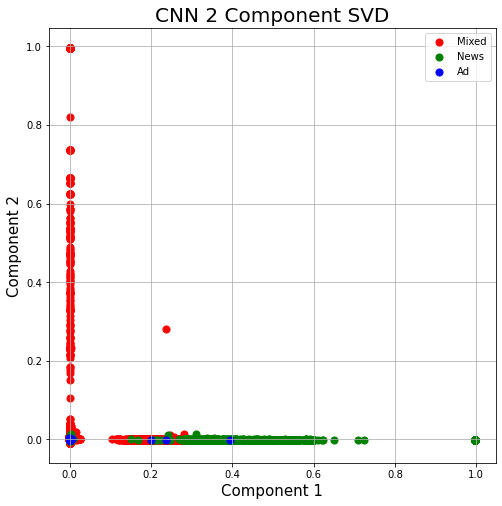

In [26]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('CNN 2 Component SVD', fontsize = 20)
targets = ['Mixed', 'News', 'Ad']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = X_new_df['Type'] == target
    ax.scatter(X_new_df.loc[indicesToKeep, 'Component 1']
               , X_new_df.loc[indicesToKeep, 'Component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Well, this isn't a very interesting visualization, but also it was mostly to see if there were visual ways to separate these. 